In [87]:
import pickle
import nltk
import json
import random
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

### Reading the cleaned tokens

In [2]:

with open("cleaned_text.txt", "rb") as fp:   # Unpickling
    cleaned_text = pickle.load(fp)
with open("cleaned_twitter.txt", "rb") as fp:   # Unpickling
    cleaned_twitter = pickle.load(fp)
cleaned_corpus=cleaned_text+cleaned_twitter
print(len(cleaned_corpus))

101098262


### Creating the sequences 

In [6]:

def create_data(length):
    seq=[]
    start=random.randint(0, len(cleaned_corpus)//2) # Used half of the corpus due to memory error
    for i in range(length,len(cleaned_corpus)//2):
        words = cleaned_corpus[i-length+start:i+start]
        line = ' '.join(words)
        seq.append(line)
        if i % 2000000==0:
            print(i , 'tokens done')
    with open('len'+str(length)+'.json', 'w') as fp:
        json.dump(seq, fp)
    
    del seq
    

In [11]:
#Sequence of length 2
create_data(2)

2000000 tokens done
4000000 tokens done
6000000 tokens done
8000000 tokens done
10000000 tokens done
12000000 tokens done
14000000 tokens done
16000000 tokens done
18000000 tokens done
20000000 tokens done
22000000 tokens done
24000000 tokens done
26000000 tokens done
28000000 tokens done
30000000 tokens done
32000000 tokens done
34000000 tokens done
36000000 tokens done
38000000 tokens done
40000000 tokens done
42000000 tokens done
44000000 tokens done
46000000 tokens done
48000000 tokens done
50000000 tokens done


In [5]:
#Sequence of length 4
create_data(4)

2000000 tokens done
4000000 tokens done
6000000 tokens done
8000000 tokens done
10000000 tokens done
12000000 tokens done
14000000 tokens done
16000000 tokens done
18000000 tokens done
20000000 tokens done
22000000 tokens done
24000000 tokens done
26000000 tokens done
28000000 tokens done
30000000 tokens done
32000000 tokens done
34000000 tokens done
36000000 tokens done
38000000 tokens done
40000000 tokens done
42000000 tokens done
44000000 tokens done
46000000 tokens done
48000000 tokens done
50000000 tokens done


In [6]:
#Sequence of length 7
create_data(7)

2000000 tokens done
4000000 tokens done
6000000 tokens done
8000000 tokens done
10000000 tokens done
12000000 tokens done
14000000 tokens done
16000000 tokens done
18000000 tokens done
20000000 tokens done
22000000 tokens done
24000000 tokens done
26000000 tokens done
28000000 tokens done
30000000 tokens done
32000000 tokens done
34000000 tokens done
36000000 tokens done
38000000 tokens done
40000000 tokens done
42000000 tokens done
44000000 tokens done
46000000 tokens done
48000000 tokens done
50000000 tokens done


### Encoding Data and splitting it into x and y

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
import pickle
import numpy as np
def encoding_data(length):
    with open('len'+str(length)+'.json', 'r') as fp:
        seq=json.load( fp)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(seq[:100000])
    
    sequences = tokenizer.texts_to_sequences(seq[:100000])
    
    sequences=np.array(sequences)
    vocab=len(tokenizer.word_counts)+1
    data_x=sequences[:,:-1]
    data_y=sequences[:,-1]
    data_y = to_categorical(data_y, num_classes=vocab)
    words_to_index = tokenizer.word_index
    with open('tokenizer_len'+str(length)+'.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    del seq
    return data_x,data_y,vocab,words_to_index

Using TensorFlow backend.


In [3]:
'''
#x,y,v=encoding_data(2)
import numpy as np 
embeddings_index=np.load('embeddings_index.npy',allow_pickle=True)
embeddings_index=dict(enumerate(embeddings_index.flatten(), 1))
'''

In [13]:
'''
embeddings_index = dict()
f = open('glove.42B.300d.txt',encoding='UTF-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

import numpy as np
np.save('embeddings_index.npy',embeddings_index)
'''

In [4]:
'''
def embedding(vocab_size,wti):
    embedding_matrix = np.zeros((vocab_size, 300))
    for word, i in wti.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix
'''

In [3]:
#Attention Model for classification 
#Code Reference below:
#https://www.analyticsvidhya.com/blog/2019/11/comprehensive-guide-attention-mechanism-deep-learning/#:~:text=Let's%20not%20implement%20a%20simple,Keras%20custom%20layer%20generation%20rule.
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
class attention(Layer):
    def init(self):
        super(attention,self).__init__()
    def build(self,input_shape):
        self.W=self.add_weight(name='att_weight',shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name='att_bias',shape=(input_shape[-2],1),initializer="zeros")        
        super(attention, self).build(input_shape)
    def call(self,x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        return K.sum(output, axis=1)

### Preparing the LSTM models

In [4]:
def lstm_model(length,unit1,n):
    import matplotlib.pyplot as plt
    from tensorflow.keras.regularizers import l2
    from tensorflow.keras.layers import LSTM, Activation, Dropout, Dense, Input,Embedding,Bidirectional
    from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,LearningRateScheduler,EarlyStopping
    from tensorflow.keras.models import Model,Sequential,save_model
    from tensorflow.keras.optimizers import Adam
    # Calling the encoding function to get the data of specified length and the vocabulary
    data_x,data_y,v,wti=encoding_data(length) 
    print("Data Encoded")
    print("Data_x",data_x[:5])
    print("Data_y",data_y[:5])
    print("Vocab_Size",v)
   
    # Preparing the model based on the inputs of unit1 ,unit2 and vocab values 
    model = Sequential()
    #model.add(Embedding(input_dim=v, output_dim=300 , input_length=length-1, weights = [embed_matrix], trainable=False))
    model.add(Embedding(v, length-1, input_length=length-1))
    model.add(Bidirectional(LSTM(unit1, return_sequences=True)))
    model.add(attention())
    #model.add(Dropout(0.5))
    #model.add(Dense(50, activation='relu'))
    model.add(Dense(v, activation='softmax'))
    print(model.summary())
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
    filepath="lstmatt_len"+str(length)+".hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
    '''
    def scheduler(epoch):
        
        if epoch < 60:
            return 0.001
        elif epoch < 100:
            return 0.0005
        else:
            return 0.0001
    '''
    #lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=3, min_lr=0.0001,min_delta=0.5,verbose=1)
    #es = EarlyStopping(monitor='val_loss', patience=5,min_delta=0.1,verbose=1)
    callbacks_list = [checkpoint]
    # fit model with epochs 130 
    
    history=model.fit(data_x, data_y,batch_size=128, epochs=n,callbacks=callbacks_list)
    
    del data_x,data_y,v,wti
    
    # Plotting the loss and accuracy achieved by the model in each epoch
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,10))
    ax[0].plot(history.history['loss'])
    ax[1].plot(history.history['accuracy'])
    ax[0].set_title('model loss')
    ax[1].set_title('model Accuracy')
    ax[0].set_ylabel('loss')
    ax[0].set_xlabel('epoch')
    ax[1].set_ylabel('accuracy')
    ax[1].set_xlabel('epoch')
    fig.tight_layout(pad=10.0)
    plt.show()

Data Encoded
Data_x [[  1]
 [660]
 [ 30]
 [ 20]
 [ 10]]
Data_y [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
Vocab_Size 16397
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1, 1)              16397     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1, 64)             8704      
_________________________________________________________________
attention_1 (attention)      (None, 64)                65        
_________________________________________________________________
dense_1 (Dense)              (None, 16397)             1065805   
Total params: 1,090,971
Trainable params: 1,090,971
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/60
782/782 [===========

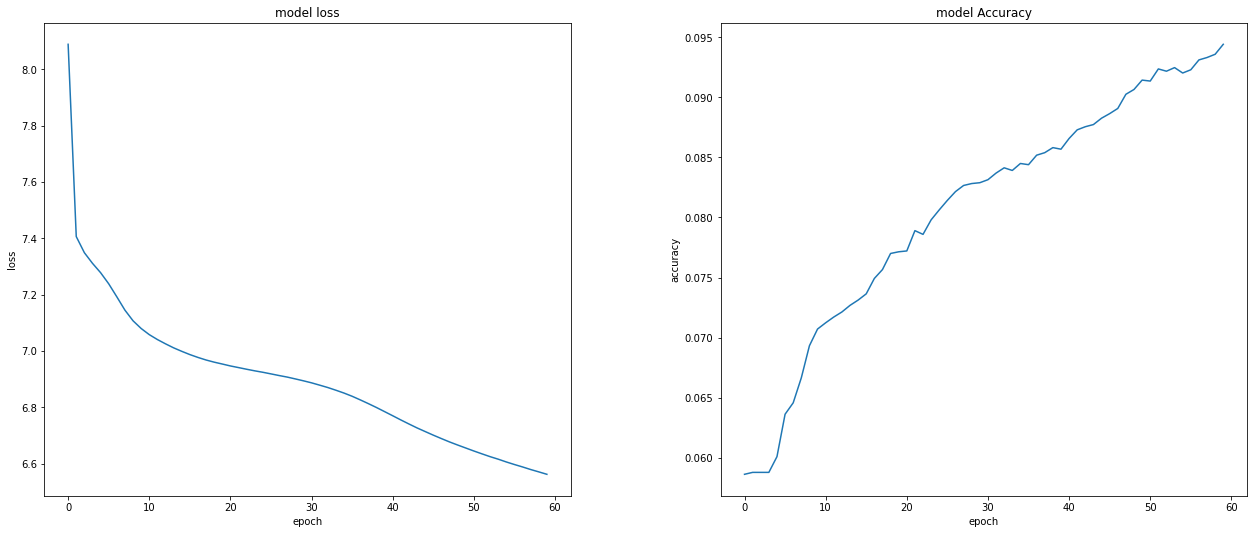

In [6]:
#Here the history is of length 1 ,Bidirectional LSTM layer has 300 units and LSTM layer has 100 units
lstm_model(2,32,60)

Data Encoded
Data_x [[  408  1056 16260]
 [ 1056 16260    12]
 [16260    12     6]
 [   12     6     4]
 [    6     4   499]]
Data_y [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Vocab_Size 16262
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 3, 3)              48786     
_________________________________________________________________
bidirectional (Bidirectional (None, 3, 128)            34816     
_________________________________________________________________
attention (attention)        (None, 128)               131       
_________________________________________________________________
dense (Dense)                (None, 16262)             2097798   
Total params: 2,181,531
Trainable params: 2,181,531
Non-trainable params: 0
__________________________________

625/625 [==============================] - 160s 256ms/step - loss: 3.6976 - accuracy: 0.2934 - val_loss: 10.0158 - val_accuracy: 0.0715

Epoch 00067: loss improved from 3.79653 to 3.77299, saving model to lstmatt_len4.hdf5
Epoch 68/80
625/625 [==============================] - 174s 278ms/step - loss: 3.6680 - accuracy: 0.2992 - val_loss: 10.0393 - val_accuracy: 0.0737

Epoch 00068: loss improved from 3.77299 to 3.74981, saving model to lstmatt_len4.hdf5
Epoch 69/80
625/625 [==============================] - 156s 249ms/step - loss: 3.6443 - accuracy: 0.3022 - val_loss: 10.0505 - val_accuracy: 0.0715

Epoch 00069: loss improved from 3.74981 to 3.72796, saving model to lstmatt_len4.hdf5
Epoch 70/80
625/625 [==============================] - 212s 339ms/step - loss: 3.6317 - accuracy: 0.3047 - val_loss: 10.0796 - val_accuracy: 0.0728

Epoch 00070: loss improved from 3.72796 to 3.70595, saving model to lstmatt_len4.hdf5
Epoch 71/80
625/625 [==============================] - 195s 313ms/step -

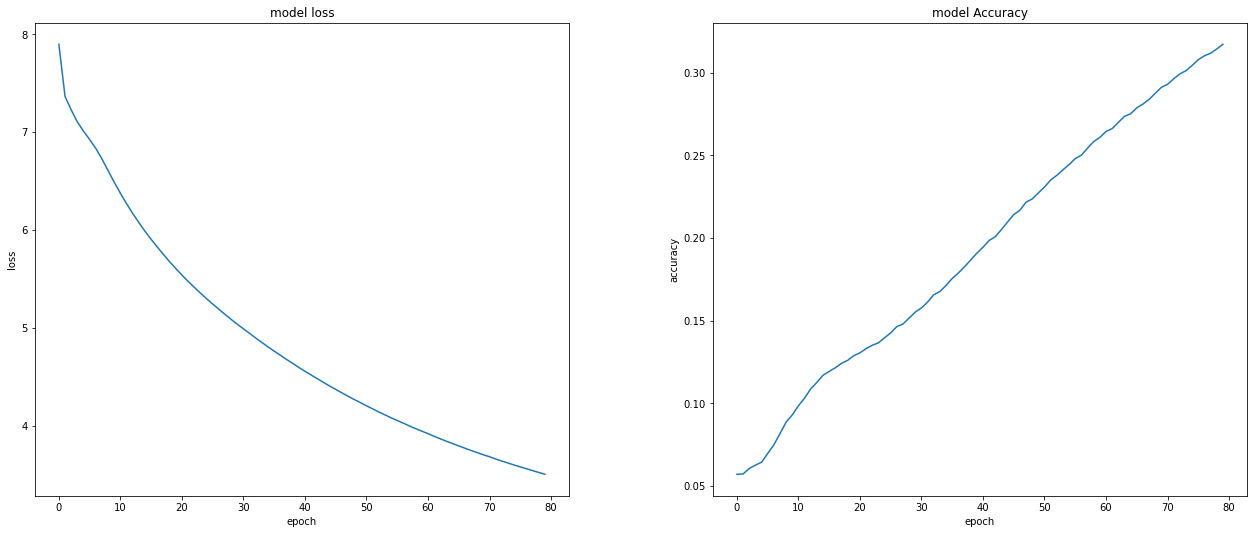

In [5]:
#Here the history is of length 3 ,Bidirectional LSTM layer has 250 units and LSTM layer has 100 units
lstm_model(4,64,80)

Data Encoded
Data_x [[    8    87 16394  3393    55     2]
 [   87 16394  3393    55     2   130]
 [16394  3393    55     2   130     4]
 [ 3393    55     2   130     4  1313]
 [   55     2   130     4  1313     8]]
Data_y [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Vocab_Size 16395
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 6, 6)              98370     
_________________________________________________________________
bidirectional (Bidirectional (None, 6, 128)            36352     
_________________________________________________________________
attention (attention)        (None, 128)               134       
_________________________________________________________________
dense (Dense)                (None, 16395)             2114955   
Total params: 2,249,

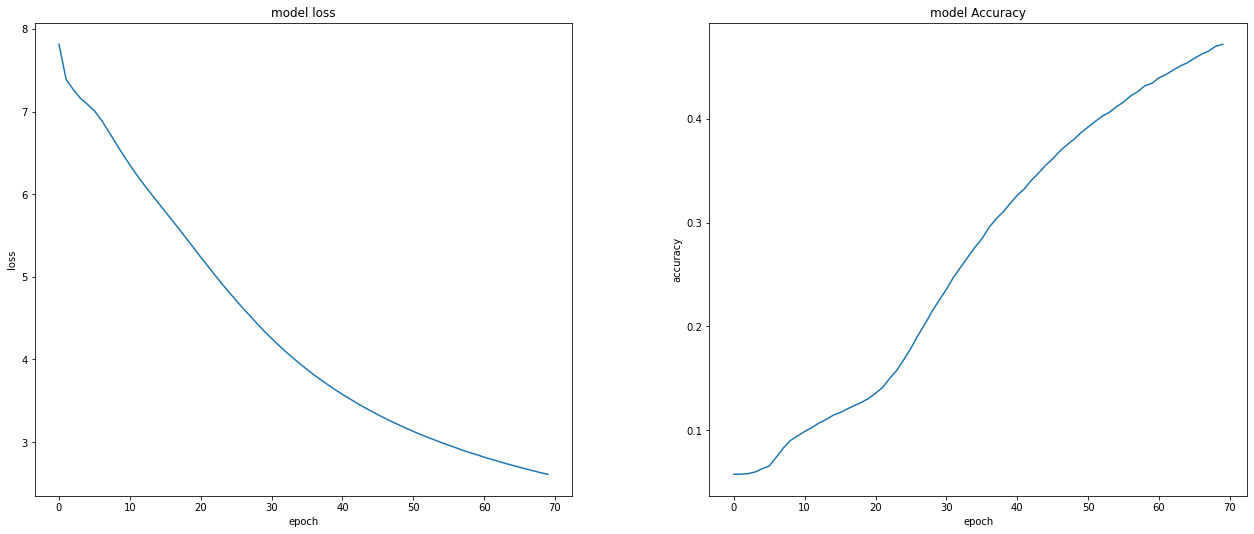

In [5]:
#Here the history is of length 6 ,Bidirectional LSTM layer has 150 units and LSTM layer has 50 units
lstm_model(7,64,70)

### Creating test data to test the models

In [41]:
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
import pickle
import numpy as np

from tensorflow.keras.preprocessing.sequence import pad_sequences
'''
start - random integer that indicates the starting index of tokens in the test data
temp_length - length of each line in the test corpus from which test data will be created
length - length of history + next word in the test data
'''
def create_testdata2(start,temp_length,length):
    seq=[]
    
    for i in range(temp_length,50000):
        words = cleaned_corpus[i-temp_length+start:i+start]
        line = ' '.join(words)
        seq.append(line)
        if i % 10000==0:
            print(i , 'tokens done')
    with open('tokenizer_len'+str(length)+'.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)
    
    
    sequences = tokenizer.texts_to_sequences(seq)
    sequences = pad_sequences(sequences, maxlen=length, truncating='pre')
    sequences=np.array(sequences)
    
    vocab=len(tokenizer.word_counts)+1
    print(vocab)
    data_x=sequences[:,:-1]
    data_y=sequences[:,-1]
    data_y = to_categorical(data_y, num_classes=vocab)
    del seq,sequences
    return data_x,data_y
    

In [16]:
#Function for generation data for error analysis
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
import pickle
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
'''
start - random integer that indicates the starting index of tokens in the test data
temp_length - length of each line in the test corpus from which test data will be created
length - length of history + next word in the test data
'''
def create_errordata(start,temp_length,length):
    seq=[]
    
    for i in range(temp_length,100):
        words = cleaned_corpus[i-temp_length+start:i+start]
        line = ' '.join(words)
        seq.append(line)
        
    with open('tokenizer_len'+str(length)+'.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)
    
    
    sequences = tokenizer.texts_to_sequences(seq)
    sequences = pad_sequences(sequences, maxlen=length, truncating='pre')
    sequences=np.array(sequences)
    
    vocab=len(tokenizer.word_counts)+1
    print(vocab)
    data_x=sequences[:,:-1]
    data_y=sequences[:,-1]
    data_y = to_categorical(data_y, num_classes=vocab)
    del seq,sequences
    return data_x,data_y
    

In [59]:
###Error Analysis funtion
def error_analysis(model,x,y,length):
    pred_y=model.predict(x)
    error=np.zeros(len(y))
    for i in range(len(pred_y)):
        for j in range(len(pred_y[i])):
            error[i] += -y[i][j]*np.log(pred_y[i][j])
            
      
    with open('tokenizer_len'+str(length)+'.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)
    x_words=tokenizer.sequences_to_texts(x)
    
    error_df =pd.DataFrame({'x':x_words, 'error':error})
    error_df=error_df.sort_values(by='error',ascending=False)
    return error_df

In [128]:
#This function draws some plots using the input text of worst and best predicted data points.
def eda_on_error(error_df):
    from collections import Counter
    import seaborn as sns
    error_df['x']=error_df['x'].astype('str')
    worst_predicted=error_df.loc[error_df['error']>8]
    best_predicted=error_df.loc[error_df['error']<=8]
    wordcloud_worst = WordCloud().generate(' '.join(worst_predicted['x']))
    wordcloud_best = WordCloud().generate(' '.join(best_predicted['x']))
    worst_words = ' '.join(worst_predicted['x']).split(' ')
    best_words = ' '.join(best_predicted['x']).split(' ')

    worst_counts= Counter(worst_words)
    best_counts= Counter(best_words)
    fig, axs = plt.subplots(1, 2,figsize=(20,5),gridspec_kw={'width_ratios': [1,2]})

    axs[0].imshow(wordcloud_worst, interpolation='bilinear')
    axs[0].set_title('Wordcloud of worst input words')
    labels, values = zip(*worst_counts.items())
    indSort = np.argsort(values)[::-1]
    labels = np.array(labels)[indSort]
    values = np.array(values)[indSort]
    sns.barplot(labels[:10],values[:10],ax=axs[1])
    axs[1].set_title('Histogram of top 10 worst input words')
    axs[1].set_xlabel('Words')
    axs[1].set_ylabel('Frequency')
    plt.show()
    
    
    fig, axs = plt.subplots(1, 2,figsize=(20,5),gridspec_kw={'width_ratios': [1,2]})
    axs[0].imshow(wordcloud_best, interpolation='bilinear')
    axs[0].set_title('Wordcloud of best input words')
    labels, values = zip(*best_counts.items())
    indSort = np.argsort(values)[::-1]
    labels = np.array(labels)[indSort]
    values = np.array(values)[indSort]
    sns.barplot(labels[:10],values[:10],ax=axs[1])
    axs[1].set_title('Histogram of top 10 best input words')
    axs[1].set_xlabel('Words')
    axs[1].set_ylabel('Frequency')
    plt.show()
    

In [6]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
file="lstmatt_len7.hdf5"
model_len7 = load_model(file, custom_objects={'attention': attention})
model_len7.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
    
file="lstmatt_len4.hdf5"
model_len4 = load_model(file, custom_objects={'attention': attention})
model_len4.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

file="lstmatt_len2.hdf5"
model_len2 = load_model(file , custom_objects={'attention': attention})
model_len2.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

In [37]:
# Setting the start and temp_length
start=random.randint(1, 1000)
temp_length=random.randint(7, 10)
print(start,temp_length)

191 7


In [12]:
len2_x,len2_y=create_testdata2(start,temp_length,2)
model_len2.evaluate(x=len2_x,y=len2_y)
del len2_x,len2_y

10000 tokens done
20000 tokens done
30000 tokens done
40000 tokens done
16397
1563/1563 [==============================] - 67s 37ms/step - loss: 7.0989 - accuracy: 0.0850


With only 1 word as history, loss achieved is 7.09

In [42]:
len4_x,len4_y=create_testdata2(start,temp_length,4)
model_len4.evaluate(x=len4_x,y=len4_y)
del len4_x,len4_y

10000 tokens done
20000 tokens done
30000 tokens done
40000 tokens done
16262
1563/1563 [==============================] - 41s 23ms/step - loss: 8.8459 - accuracy: 0.0781


With  3 words as history, loss achieved is 8.86

In [61]:
len7_x,len7_y=create_testdata2(start,temp_length,7)
model_len7.evaluate(x=len7_x,y=len7_y)
del len7_x,len7_y

10000 tokens done
20000 tokens done
30000 tokens done
40000 tokens done
16395
1563/1563 [==============================] - 41s 23ms/step - loss: 9.2400 - accuracy: 0.07101s -


With 6 words as history, loss achieved is 9.24

#### Error Analysis for unigram data points

In [33]:
len2_x,len2_y=create_errordata(start,temp_length,2)
len2_error=error_analysis(model_len2,len2_x,len2_y,2)
del len2_x,len2_y
len2_error.head(20)

16397


,x,error
3,,22.054495
85,,22.054495
86,,14.576693
66,employee,14.159409
45,jackpot,13.855607
48,government,12.731485
82,block,12.070144
26,director,10.861241
56,report,10.846756
14,failed,10.757914


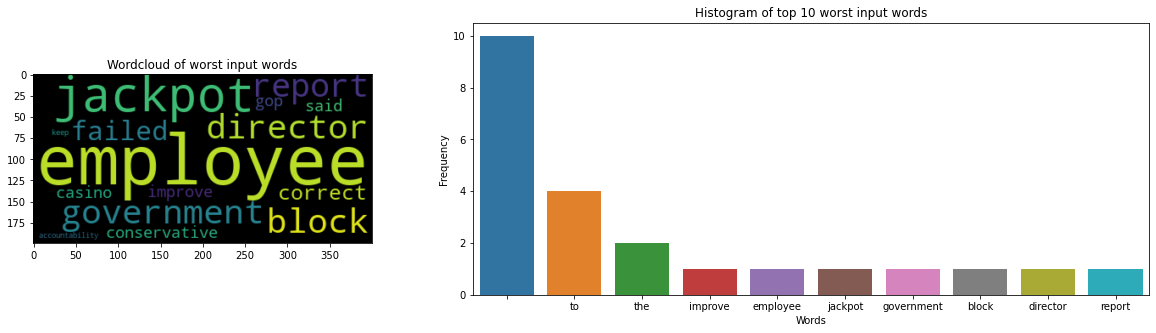

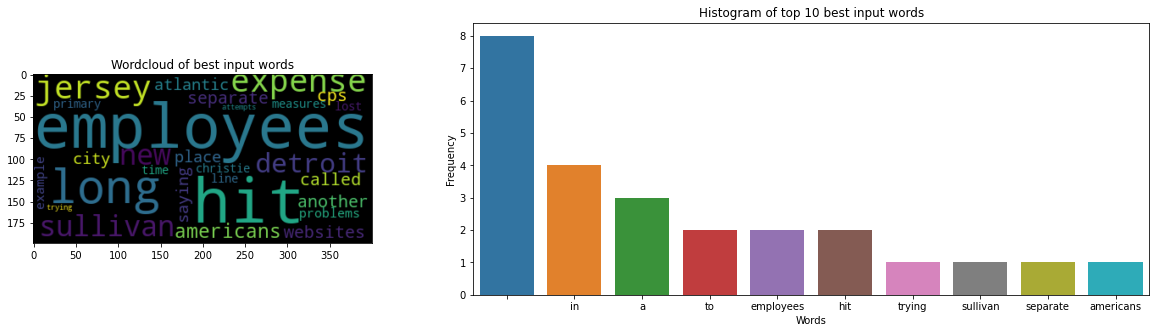

In [129]:
eda_on_error(len2_error)

#### Error Analysis for trigram data points

In [50]:
len4_x,len4_y=create_errordata(start,temp_length,4)
len4_error=error_analysis(model_len4,len4_x,len4_y,4)
del len4_x,len4_y
len4_error.head(50)

16262


,x,error
40,line of failed,23.462521
66,gop primary the,22.989922
82,in the report,22.296194
55,director steve a,19.561069
59,who lost to,18.894049
85,sullivan called on,18.464777
74,here at government,18.330738
30,a separate day,17.446041
91,problems to improve,16.066223
92,problems to improve,16.066223


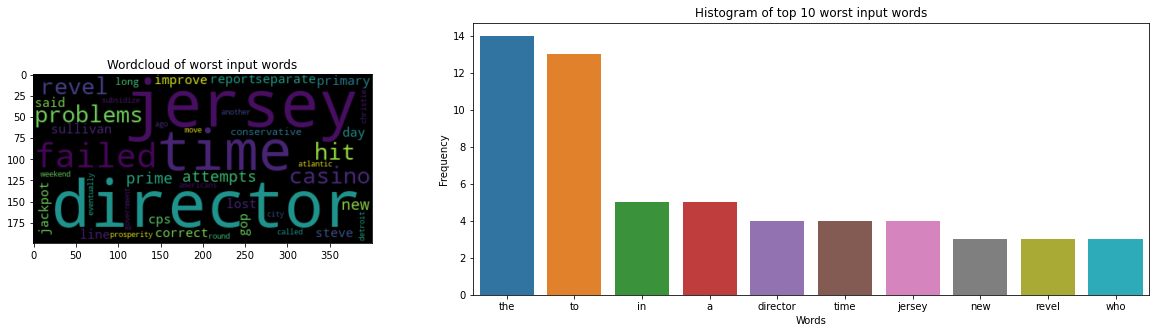

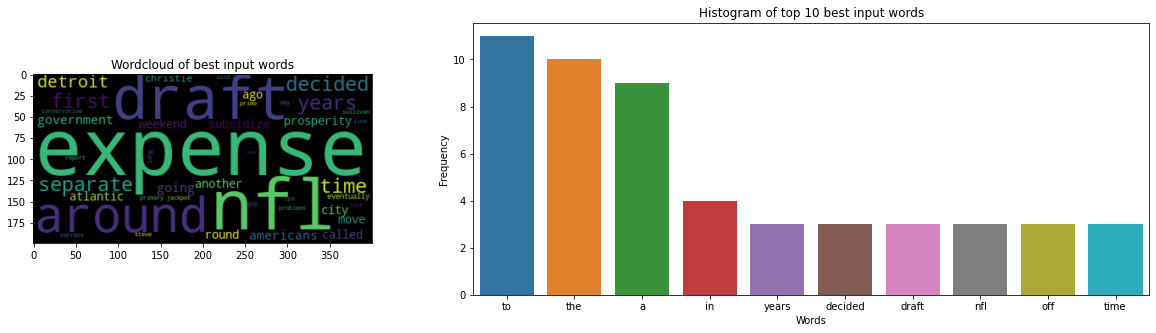

In [130]:
eda_on_error(len4_error)

#### Error Analysis for 6-gram data points

In [60]:
len7_x,len7_y=create_errordata(start,temp_length,7)
len7_error=error_analysis(model_len7,len7_x,len7_y,7)
del len7_x,len7_y
len7_error.head(50)

16395


,x,error
74,hit the jackpot here at government,24.284920
82,time and again in the report,23.024176
85,in the report sullivan called on,19.203878
16,the draft from the weekend to,18.828316
86,the report sullivan called on cps,18.112316
87,report sullivan called on cps to,16.573584
91,cps to correct problems to improve,16.366970
54,new jersey director steve,16.324947
92,to correct problems to improve employee,15.863632
88,sullivan called on cps to correct,15.122622


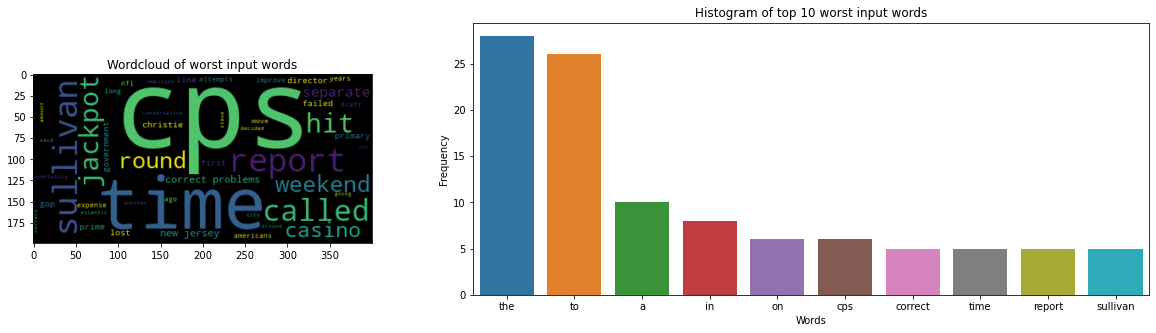

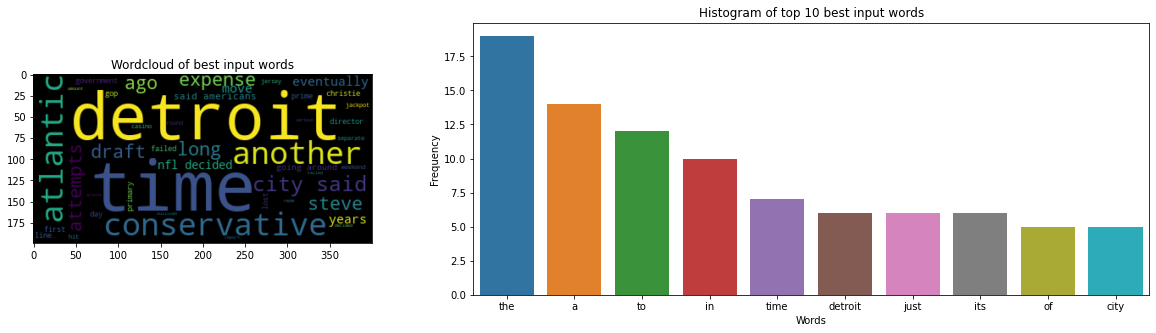

In [131]:
eda_on_error(len7_error)

- From the EDA of the above 3 cases , I conclude that stopwords mainly overlap in best and worst prediction data points.The rest are distinct.

In [62]:
del cleaned_corpus
del cleaned_text
del cleaned_twitter

### Predicting Next Word

In [63]:
import re 
from nltk.tokenize import word_tokenize
def extra_space(text):
    new_text= re.sub("\s+"," ",text)
    return new_text
def sp_charac(text):
    new_text=re.sub("[^0-9A-Za-z ]", "" , text)
    return new_text
def tokenize_text(text):
    new_text=word_tokenize(text)
    return new_text

In [76]:

def predict_next():
    import tensorflow as tf
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from tensorflow.keras.models import load_model
    from tensorflow.keras.optimizers import Adam
    import pickle
    import time
  
    with open('tokenizer_len7.pickle', 'rb') as handle:
        tokenizer_len7 = pickle.load(handle)

    with open('tokenizer_len4.pickle', 'rb') as handle:
        tokenizer_len4 = pickle.load(handle)
    with open('tokenizer_len2.pickle', 'rb') as handle:
        tokenizer_len2 = pickle.load(handle)
    
    file="lstmatt_len7.hdf5"
    model_len7 = load_model(file ,custom_objects={'attention': attention})
    model_len7.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
    
    file="lstmatt_len4.hdf5"
    model_len4 = load_model(file, custom_objects={'attention': attention})
    model_len4.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

    file="lstmatt_len2.hdf5"
    model_len2 = load_model(file , custom_objects={'attention': attention})
    model_len2.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
    while(True):
        text=input()
        start= time.time()
        cleaned_text=extra_space(text)
        cleaned_text=sp_charac(cleaned_text)
        tokenized=tokenize_text(cleaned_text)
    
        line = ' '.join(tokenized)
        
    
        if len(tokenized)==1:
        
            encoded_text = tokenizer_len2.texts_to_sequences([line])
            pad_encoded = pad_sequences(encoded_text, maxlen=1, truncating='pre')
    
            for i in (model_len2.predict(pad_encoded)[0]).argsort()[-3:][::-1]:
    
    
                pred_word = tokenizer_len2.index_word[i]
                print("Next word suggestion:",pred_word)
        elif len(tokenized)<4:
            encoded_text = tokenizer_len4.texts_to_sequences([line])
            pad_encoded = pad_sequences(encoded_text, maxlen=3, truncating='pre')
           
            for i in (model_len4.predict(pad_encoded)[0]).argsort()[-3:][::-1]:
    
    
                pred_word = tokenizer_len4.index_word[i]
                print("Next word suggestion:",pred_word)
        else:
            encoded_text = tokenizer_len7.texts_to_sequences([line])
            pad_encoded = pad_sequences(encoded_text, maxlen=6, truncating='pre')
    
            for i in (model_len7.predict(pad_encoded)[0]).argsort()[-3:][::-1]:
    
    
                pred_word = tokenizer_len7.index_word[i]
                print("Next word suggestion:",pred_word)
        print('Time taken: ',time.time()-start)
   

In [77]:
predict_next()

what a lovely
Next word suggestion: water
Next word suggestion: air
Next word suggestion: man
Time taken:  1.0507631301879883
because there is no
Next word suggestion: heavy
Next word suggestion: towers
Next word suggestion: chance
Time taken:  1.575056791305542
maybe I should be
Next word suggestion: a
Next word suggestion: forced
Next word suggestion: charged
Time taken:  0.05898880958557129
very 
Next word suggestion: be
Next word suggestion: than
Next word suggestion: have
Time taken:  1.1010732650756836
in 
Next word suggestion: the
Next word suggestion: a
Next word suggestion: his
Time taken:  0.06171011924743652
There
Next word suggestion: and
Next word suggestion: was
Next word suggestion: said
Time taken:  0.08094501495361328


KeyboardInterrupt: Interrupted by user